In [1]:
import os
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import csv
import sys
from pathlib import Path
import copy

import matplotlib.pyplot as plt
%matplotlib inline

# path to stylegan encoder on server
sys.path.insert(1, '/home/shavit/APhotoADay/data/stylegan-encoder')

from encoder.generator_model import Generator
import dnnlib
import dnnlib.tflib as tflib
import config

from IPython.display import Markdown, display

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shavit/miniconda3/envs/myenv/lib/python3

/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shavit/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shavit/miniconda3/e

In [2]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)
    
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

printmd("Please enter number of dimensions:", color="blue")
dimensions = int(input())

printmd("Please choose data [1-external, 2-internal]:", color="red")
data_loc = int(input())

data_method = "external"
if data_loc == 2:
    data_method = "internal"

<span style='color:blue'>Please enter number of dimensions:</span>

 100


<span style='color:red'>Please choose data [1-external, 2-internal]:</span>

 1


In [3]:
os.getcwd()
# os.chdir("/home/shavit/APhotoADay/True_vs_Learned")

'/home/shavit/APhotoADay/True_vs_Learned'

In [20]:
# Load Data

# data is a list of lists where the first element is the age and the second is the latent representation

# i.e. data[0] contains the entire first video
# data[0][0] is a list of two values (the first age of the video, and the latent representation of the photo at that age)

data = []

video = []

paths = ["regression_data/video1",
         "regression_data/video2",
         "regression_data/video3"]

for path in paths:
    
    for photo in os.listdir(path):

        latent_representation = np.load(path + "/" + photo).flatten()
        age = int(Path(photo).stem)

        video.append([age, latent_representation])
        video.sort()
        
    data.append(video)
    video = []

In [21]:
# Find most linear components in data

# find differences
differences = []

for person in data:
    for j, photo in enumerate(person):
        if j == 0:
            continue
        differences.append(photo[1] - person[j - 1][1])

differences = np.array(differences)

differences_aux = differences.transpose()

normalized_differences_aux = preprocessing.normalize(np.array(differences_aux))

variances = []
normalized_variances = []

for values in differences_aux:
    variances.append(np.var(values))

for values in normalized_differences_aux:
    normalized_variances.append(np.var(values))
    
# list of components sorted by variance
smallest_variance_components = np.argsort(variances)
normalized_smallest_variance_components = np.argsort(normalized_variances)

In [22]:
# dimensions = 4806

In [23]:
data_first_10 = copy.deepcopy(data)
data_most_linear = copy.deepcopy(data)
data_normalized_most_linear = copy.deepcopy(data)

In [24]:
for i, person in enumerate(data_first_10):
    for j, photo in enumerate(person):
        #print ("first 10 = ")
        #print (data_first_10[i][j][1][0:10])
        data_first_10[i][j][1] =  np.concatenate((data_first_10[i][j][1][0:dimensions], np.zeros(512*18 - dimensions)))

In [25]:
smallest_variance_components = np.concatenate((smallest_variance_components[0:dimensions], np.ones(512*18 - dimensions) * (-1)))

for i, person in enumerate(data_most_linear):
    for j, photo in enumerate(person):
        for k, component in enumerate(photo[1]):
            if (k in smallest_variance_components) == False:
                data_most_linear[i][j][1][k] = 0

In [26]:
normalized_smallest_variance_components = np.concatenate((normalized_smallest_variance_components[0:dimensions], np.ones(512*18 - dimensions) * (-1)))

for i, person in enumerate(data_normalized_most_linear):
    for j, photo in enumerate(person):
        for k, component in enumerate(photo[1]):
            if (k in normalized_smallest_variance_components) == False:
                data_normalized_most_linear[i][j][1][k] = 0

In [27]:
def findRegressor(start_ages, start_photos, target_ages, target_photos):

    X = []
    Y = []

    for i in range(len(start_photos)):
        X.append(np.concatenate([start_photos[i], start_ages[i], target_ages[i]], axis=None))
        Y.append(target_photos[i] - start_photos[i])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    regressor = LinearRegression(copy_X = True)  
    regressor.fit(X_train, Y_train)

    #print("accuracy = " + str(testModel(X_train, Y_train, regressor)))

    return regressor, np.array(X_test).astype(np.float64), np.array(Y_test).astype(np.float64), np.array(X_train).astype(np.float64), np.array(Y_train).astype(np.float64)

In [28]:
# Regression for first 10 dimensions
start_ages_f10 = []
start_photos_f10 = []
target_ages_f10 = []
target_photos_f10 = []

for person in data_first_10:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_f10.append(first_photo)
        start_ages_f10.append(first_age)
        target_ages_f10.append(photo[0])
        target_photos_f10.append(photo[1])

regressor_first_10, X_test_f10, Y_test_f10, X_train_f10, Y_train_f10 = findRegressor (start_ages_f10, start_photos_f10, target_ages_f10, target_photos_f10)


In [ ]:
predicted_differences_f10 = regressor_first_10.predict(X_test_f10)
predicted_results_f10 = []
for i, difference in enumerate(predicted_differences_f10):
    predicted_results_f10.append(start_photos_f10[i] + difference)
MSE_f10 = metrics.mean_squared_error (Y_test_f10, predicted_results_f10)
predicted_differences_f10_train = regressor_first_10.predict(X_train_f10)
predicted_results_f10_train = []
for i, difference in enumerate(predicted_differences_f10_train):
    predicted_results_f10_train.append(start_photos_f10[i] + difference)
MSE_f10_train = metrics.mean_squared_error (predicted_differences_f10_train, Y_train_f10)

print (MSE_f10_train)
print (MSE_f10)

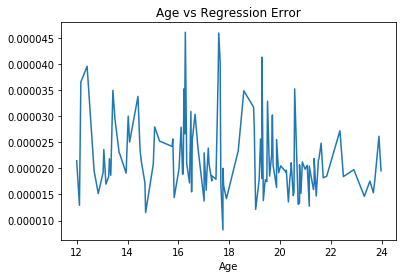

In [64]:
# New code
age_specific_MSE_f10 = []

for i, age in enumerate(Y_test_f10):
    this_MSE = metrics.mean_squared_error (Y_test_f10[i], predicted_results_f10[i])
    age_specific_MSE_f10.append([X_test_f10[i][512*18 + 1], this_MSE])

age_specific_MSE_f10.sort()

path_e = "regression_data/results/dimensions/first_" + str(dimensions) + data_method
if not os.path.exists(path_e):
    os.mkdir(path_e)

graph_name = path_e + "/error_graph"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_f10:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [ ]:
# Regression for smallest variance
start_ages_sv = []
start_photos_sv = []
target_ages_sv = []
target_photos_sv = []

for person in data_most_linear:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_sv.append(first_photo)
        start_ages_sv.append(first_age)
        target_ages_sv.append(photo[0])
        target_photos_sv.append(photo[1])

regressor_smallest_variance, X_test_sv, Y_test_sv, X_train_sv, Y_train_sv = findRegressor (start_ages_sv, start_photos_sv, target_ages_sv, target_photos_sv)


In [ ]:
predicted_differences_sv = regressor_smallest_variance.predict(X_test_sv)
predicted_results_sv = []
for i, difference in enumerate(predicted_differences_sv):
    predicted_results_sv.append(start_photos_sv[i] + difference)
MSE_sv = metrics.mean_squared_error (Y_test_sv, predicted_results_sv)
predicted_differences_sv_train = regressor_smallest_variance.predict(X_train_sv)
predicted_results_sv_train = []
for i, difference in enumerate(predicted_differences_sv_train):
    predicted_results_sv_train.append(start_photos_sv[i] + difference)
MSE_sv_train = metrics.mean_squared_error (predicted_differences_sv_train, Y_train_sv)

print (MSE_sv_train)
print (MSE_sv)

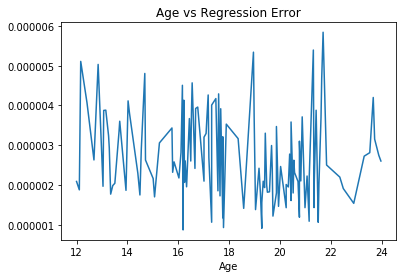

In [67]:
# New code
age_specific_MSE_sv = []

for i, age in enumerate(Y_test_sv):
    this_MSE = metrics.mean_squared_error (Y_test_sv[i], predicted_results_sv[i])
    age_specific_MSE_sv.append([X_test_sv[i][512*18 + 1], this_MSE])

age_specific_MSE_sv.sort()

path_e = "regression_data/results/dimensions/linear_first_" + str(dimensions) + data_method
if not os.path.exists(path_e):
    os.mkdir(path_e)

graph_name = path_e + "/error_graph"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_sv:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [ ]:
# Regression for smallest variance
start_ages_nsv = []
start_photos_nsv = []
target_ages_nsv = []
target_photos_nsv = []

for person in data_normalized_most_linear:
    first_age = person[0][0]
    first_photo = person[0][1]
    for photo in person:
        start_photos_nsv.append(first_photo)
        start_ages_nsv.append(first_age)
        target_ages_nsv.append(photo[0])
        target_photos_nsv.append(photo[1])

regressor_normalized_smallest_variance, X_test_nsv, Y_test_nsv, X_train_nsv, Y_train_nsv = findRegressor (start_ages_nsv, start_photos_nsv, target_ages_nsv, target_photos_nsv)


In [ ]:
predicted_differences_nsv = regressor_normalized_smallest_variance.predict(X_test_nsv)
predicted_results_nsv = []
for i, difference in enumerate(predicted_differences_nsv):
    predicted_results_nsv.append(start_photos_nsv[i] + difference)
MSE_nsv = metrics.mean_squared_error (Y_test_nsv, predicted_results_nsv)
predicted_differences_nsv_train = regressor_normalized_smallest_variance.predict(X_train_nsv)
predicted_results_nsv_train = []
for i, difference in enumerate(predicted_differences_nsv_train):
    predicted_results_nsv_train.append(start_photos_nsv[i] + difference)
MSE_nsv_train = metrics.mean_squared_error (predicted_differences_nsv_train, Y_train_nsv)

print (MSE_nsv_train)
print (MSE_nsv)

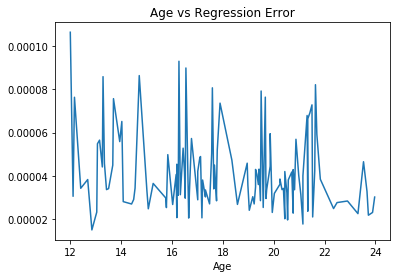

In [70]:
# New code
age_specific_MSE_nsv = []

for i, age in enumerate(Y_test_nsv):
    this_MSE = metrics.mean_squared_error (Y_test_nsv[i], predicted_results_nsv[i])
    age_specific_MSE_nsv.append([X_test_nsv[i][512*18 + 1], this_MSE])

age_specific_MSE_nsv.sort()

path_e = "regression_data/results/dimensions/norm_linear_first_" + str(dimensions) + data_method
if not os.path.exists(path_e):
    os.mkdir(path_e)

graph_name = path_e + "/error_graph"
csv_file = graph_name + ".csv"

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Age", "MSE"])
    
    for age, mse in age_specific_MSE_nsv:
        writer.writerow([(age / 365.0), mse])

# Display and save plot

data_to_plot = pd.read_csv(csv_file).set_index('Age')
data_plot = data_to_plot.plot(title = "Age vs Regression Error", legend = None)

data_plot.get_figure().savefig(graph_name + ".png")

In [71]:
def generate_image(latent_vector, size):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((size, size))

In [72]:
# Video from given picture, using our data (which specific data exactly?)

os.chdir("/home/shavit/APhotoADay/True_vs_Learned")

t_start_photos = []
t_start_ages = []
t_target_ages = []
    
t_first = np.load("regression_data/test/earl.npy").flatten()
# t_first_age = int(input("Enter your age (years): ")) * 365
t_first_age = 16 * 365

if data_loc == 2: # testing internal benchmark
    t_first = np.load("regression_data/test/internal.npy").flatten()
    t_first_age = 4380

for i in range (t_first_age, t_first_age * 2, 10):
    t_start_photos.append(t_first)
    t_start_ages.append(t_first_age)
    t_target_ages.append(i)

t_X = []
for i in range(len(t_start_photos)):
    t_X.append(np.concatenate([t_start_photos[i], t_start_ages[i], t_target_ages[i]], axis=None))

methods = ["first", "linear_first", "norm_linear_first"]
# methods = ["first"]
results_paths = []

for method in methods:
    
    results_path = "regression_data/results/dimensions/" + method + "_" + str(dimensions) + data_method
    results_paths.append(results_path)
    
    t_Y_differences = regressor_first_10.predict(t_X)
    if method == "linear_first":
        t_Y_differences = regressor_smallest_variance.predict(t_X)
    if method == "norm_linear_first":
        t_Y_differences = regressor_normalized_smallest_variance.predict(t_X)
    
    t_Y = []

    for i, difference in enumerate(t_Y_differences):
        t_Y.append(t_start_photos[i] + difference)

    if not os.path.exists(results_path):
        os.mkdir(results_path)

    frames = 60

    for i, prediction in enumerate(t_Y):
        img = generate_image(prediction, 512)
        img.save(results_path + "/" + str(i) + ".png")
        frames = i

    print(frames)

437


In [8]:
import math
framerate = math.ceil(frames / 6.0)

# framerate = math.ceil(215 / 6.0)
# results_paths = ["clean_video3"]

In [9]:
# ffmpeg -f image2 -framerate 119 -pattern_type sequence -start_number 0 -r 2 -i %d.png -vcodec libx264 -acodec aac real_broken.mp4
# ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4
# ffmpeg -itsscale 0.027 -i real.mp4 -c copy real_output.mp4
# os.getcwd()
# First, manually check current path and if it is a father folder, execute chdir 

for results_path in results_paths:

    os.chdir("/home/shavit/APhotoADay/True_vs_Learned/" + results_path)
    
#     if not os.path.exists("/home/shavit/APhotoADay/True_vs_Learned/vid1res"):
#         os.mkdir("/home/shavit/APhotoADay/True_vs_Learned/vid1res")
#     os.chdir("/home/shavit/APhotoADay/True_vs_Learned/vid1res")

    res1 = os.system("ffmpeg -f image2 -framerate " + str(framerate) + " -pattern_type sequence -start_number 0 -r 2 -i %d.png -vcodec libx264 -acodec aac real_broken.mp4")
    
    if res1 == 0:
        res2 = os.system("ffmpeg -i real_broken.mp4 -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p real.mp4")
        
        if res2 == 0:
            res3 = os.system("ffmpeg -itsscale 0.027 -i real.mp4 -c copy output.mp4")
            
            if res3 == 0:
                os.system("rm real_broken.mp4")
                os.system("rm real.mp4")